# Tải thư viện #


In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import random
import torch.optim as optim

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

In [3]:
import torchvision.transforms as T

# Tải dữ liệu

In [4]:
def parse_yolo_label(label_path, img_width, img_height):
    """
    Hàm đọc file label theo định dạng YOLO và chuyển đổi thành bounding boxes dạng pixel.
    
    Tham số:
      - label_path: đường dẫn file TXT chứa annotation.
      - img_width, img_height: kích thước ảnh (pixel) để chuyển đổi giá trị chuẩn hóa.
    
    Trả về: dictionary với key 'boxes' và 'labels'
    """
    boxes = []
    labels = []
    # Mở file label để đọc nội dung
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Nếu không đúng định dạng thì bỏ qua
            # Định dạng: class center_x center_y width height (các giá trị đã chuẩn hóa)
            cls, x_center, y_center, box_width, box_height = parts
            cls = int(cls)
            x_center = float(x_center)
            y_center = float(y_center)
            box_width = float(box_width)
            box_height = float(box_height)
            
            # Chuyển đổi sang tọa độ pixel
            abs_x_center = x_center * img_width
            abs_y_center = y_center * img_height
            abs_box_width = box_width * img_width
            abs_box_height = box_height * img_height
            
            xmin = abs_x_center - abs_box_width / 2
            ymin = abs_y_center - abs_box_height / 2
            xmax = abs_x_center + abs_box_width / 2
            ymax = abs_y_center + abs_box_height / 2
            
            boxes.append([xmin, ymin, xmax, ymax])
            # Giả sử chỉ có một lớp "fire" nên có thể đặt nhãn = cls + 1 (vì background = 0)
            labels.append(cls + 1)
    
    return {'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)}


In [5]:
class FireYoloDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        """
        Tham số:
          - images_dir: đường dẫn folder chứa ảnh.
          - labels_dir: đường dẫn folder chứa file label.
          - transforms: các biến đổi (ví dụ chuyển ảnh thành tensor).
        """
        super(FireYoloDataset, self).__init__()
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        # Lấy danh sách file ảnh có đuôi jpg, png, jpeg
        self.img_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Lấy ảnh theo chỉ số idx
        img_file = self.img_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        image = Image.open(img_path).convert("RGB")
        img_width, img_height = image.size  # Lấy kích thước ảnh (width, height)
        
        # File label có cùng tên ảnh nhưng đuôi .txt
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_file)
        
        target = parse_yolo_label(label_path, img_width, img_height)
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, target


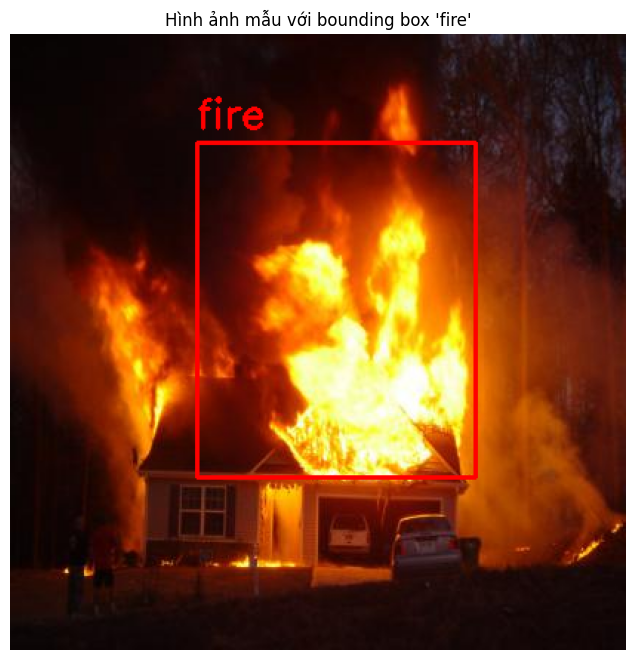

In [6]:
train_images_dir = "/kaggle/input/xulyanh/data/test/images"
train_labels_dir = "/kaggle/input/xulyanh/data/test/labels"

# Sử dụng biến đổi đơn giản: chuyển ảnh từ PIL sang Tensor
transform = T.Compose([T.ToTensor()])

dataset = FireYoloDataset(images_dir=train_images_dir,
                           labels_dir=train_labels_dir,
                           transforms=transform)

# Lấy một mẫu từ dataset (ví dụ, mẫu đầu tiên)
sample_img_tensor, sample_target = dataset[0]

# Chuyển ảnh từ tensor về dạng NumPy và tạo bản sao để đảm bảo writable
image_np = sample_img_tensor.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()


# Vẽ bounding boxes lên ảnh dựa theo 'boxes' trong target
for box in sample_target['boxes']:
    xmin, ymin, xmax, ymax = map(int, box.tolist())
    # Vẽ bounding box (màu xanh dương)
    cv2.rectangle(image_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(image_np, "fire", (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Hiển thị ảnh sử dụng Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image_np)
plt.title("Hình ảnh mẫu với bounding box 'fire'")
plt.axis("off")
plt.show()


- Hình ảnh mẫu

# Chuẩn bị data

In [7]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Định nghĩa transform (ở đây chỉ chuyển ảnh sang tensor)
transform = T.Compose([
    T.ToTensor(),
])

# Khởi tạo dataset cho từng phân chia (giả sử cấu trúc folder: data/train, data/val, data/test)
train_dataset = FireYoloDataset(images_dir='/kaggle/input/xulyanh/data/train/images',
                                  labels_dir='/kaggle/input/xulyanh/data/train/labels',
                                  transforms=transform)
val_dataset = FireYoloDataset(images_dir='/kaggle/input/xulyanh/data/val/images',
                                labels_dir='/kaggle/input/xulyanh/data/val/labels',
                                transforms=transform)
test_dataset = FireYoloDataset(images_dir='/kaggle/input/xulyanh/data/test/images',
                                labels_dir='/kaggle/input/xulyanh/data/test/labels',
                                transforms=transform)

def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# Faster R-CNN

In [11]:
import torchvision
import torchvision.models.detection as detection

# Số lớp = 2 (background và fire)
num_classes = 2

# Tải mô hình Faster R-CNN đã được tiền huấn luyện trên COCO
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Thay đổi head để phù hợp với số lớp của bài toán
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Chuyển model sang device (GPU nếu có)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training

In [15]:
import torch
import torch.optim as optim
from sklearn.metrics import classification_report

# Định nghĩa optimizer – có thể dùng Adam hoặc SGD
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Số epoch huấn luyện (bạn có thể điều chỉnh)
threshold = 0.5  # Ngưỡng để chọn dự đoán từ mô hình

for epoch in range(num_epochs):
    ### Giai đoạn huấn luyện trên tập train
    model.train()
    epoch_loss = 0.0
    for images, targets in train_loader:
        # Chuyển ảnh và target sang device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
    
    ### Giai đoạn đánh giá trên tập validation
    # Chuyển sang chế độ eval, không cần tính gradient
    model.eval()
    all_gt_labels = []   # Danh sách chứa ground truth labels từ tập val
    all_pred_labels = [] # Danh sách chứa predicted labels từ mô hình trên tập val
    
    # Với mỗi batch trong tập val
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        # Lưu lại ground truth của từng ảnh trong batch
        # Ở đây, chúng ta lấy nhãn của từng bounding box trong target
        batch_gt = []
        for t in targets:
            # Giả sử mỗi target['labels'] là tensor, chuyển sang list
            batch_gt.extend(t['labels'].cpu().tolist())
        
        with torch.no_grad():
            predictions = model(images)
        
        batch_preds = []
        # Với mỗi ảnh trong batch, lấy các predicted labels với score >= threshold
        for pred in predictions:
            # Lấy predicted labels từ key 'labels' ứng với predicted bounding boxes
            # Lọc theo ngưỡng: chỉ chọn những dự đoán mà score >= threshold
            pred_labels = []
            for label, score in zip(pred['labels'], pred['scores']):
                if score >= threshold:
                    # label là tensor, chuyển sang số nguyên
                    pred_labels.append(label.item())
            # Nếu không có dự đoán nào đáp ứng threshold, có thể gán một giá trị (ví dụ: background = 0)
            if len(pred_labels) == 0:
                pred_labels = [0]
            batch_preds.extend(pred_labels)
        
        all_gt_labels.extend(batch_gt)
        all_pred_labels.extend(batch_preds)
    
    # Sau đó chuyển lại model sang chế độ train cho epoch tiếp theo
    model.train()


Epoch 1/10, Loss: 0.2247
Epoch 2/10, Loss: 0.2058
Epoch 3/10, Loss: 0.1942
Epoch 4/10, Loss: 0.1671
Epoch 5/10, Loss: 0.1546
Epoch 6/10, Loss: 0.1322
Epoch 7/10, Loss: 0.1356
Epoch 8/10, Loss: 0.1275
Epoch 9/10, Loss: 0.1041
Epoch 10/10, Loss: 0.1095


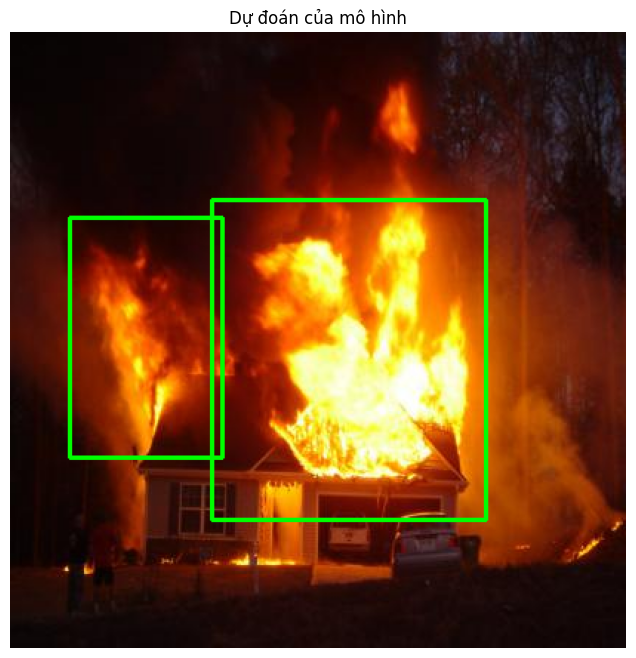

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

model.eval()

def predict_and_visualize(model, image, threshold=0.5):
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
    
    # Chuyển tensor ảnh về dạng numpy để hiển thị
    image_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()
    
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box.int().cpu().tolist()
            cv2.rectangle(image_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image_np)
    plt.title("Dự đoán của mô hình")
    plt.axis('off')
    plt.show()

sample_img, _ = test_dataset[0]
predict_and_visualize(model, sample_img, threshold=0.7)
